In [1]:
from google.colab import drive
drive.mount ('/content/drive')

Mounted at /content/drive


# Загрузка библиотек и модулей

In [2]:
!pip3 install easyocr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 31.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 813.9/813.9 kB 47.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.0/146.0 kB 15.0 MB/s eta 0:00:00


In [3]:
import os
import re
import sys
import math
import numpy as np
import pandas as pd

import warnings
import copy

import cv2

from datetime import date, datetime

import scipy.optimize
from scipy import ndimage

from PIL import Image, ImageDraw

from google.colab.patches import cv2_imshow

import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.ops.boxes import nms

import easyocr

In [ ]:
reader = easyocr.Reader(["ru"], recog_network='cyrillic_g2')

Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.1% Complete

# Распознавание изображения таблицы с RCNN

In [ ]:
crop_img = 0
# Модель RCNN для распознавания текста
def create_model(num_classes, pretrained=False):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=pretrained)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

# Алгоритм non-maximum suppression. Он объединяет похожие рамки на основе их взаимного пересечения.
def tab_predict(image, iou_threshold=0.1, threshold=0.8, scale_percent=25):
    model.eval()
    img = image
    img_ = img / 255.
    img_ = torch.from_numpy(img_).permute(2, 0, 1).unsqueeze(0).to(torch.float).to(device)
    predict = model(img_)
    ind = nms(predict[0]['boxes'], predict[0]['scores'], iou_threshold).detach().cpu().numpy()
    for i, box in enumerate(predict[0]['boxes'][ind]):
        if predict[0]['scores'][i] > threshold:
            cv2.rectangle(img,
                    (int(box[0]-100), int(box[1]-15)),
                    (int(box[2]+100), int(box[3]+25)),
                    (255, 0, 0))
            global crop_img
            crop_img = img[(int(box[1]-15)):(int(box[3]+25)), (int(0)):(int(img.shape[1]))]

    return crop_img

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model = create_model(2).to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/Yandex_workshop/models/fasterrcnn_resnet50_fpn.pth', map_location=torch.device('cpu')))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 104MB/s]


<All keys matched successfully>

# Предобработка изображения таблицы с Page-dewarp

In [ ]:
# for some reason pylint complains about cv2 members being undefined :(
# pylint: disable=E1101

PAGE_MARGIN_X = 1       # reduced px to ignore near L/R edge
PAGE_MARGIN_Y = 1       # reduced px to ignore near T/B edge

OUTPUT_ZOOM = 1.0        # how much to zoom output relative to *original* image
OUTPUT_DPI = 300         # just affects stated DPI of PNG, not appearance
REMAP_DECIMATE = 16      # downscaling factor for remapping image

ADAPTIVE_WINSZ = 55      # window size for adaptive threshold in reduced px

TEXT_MIN_WIDTH = 15      # min reduced px width of detected text contour
TEXT_MIN_HEIGHT = 2      # min reduced px height of detected text contour
TEXT_MIN_ASPECT = 1.5    # filter out text contours below this w/h ratio
TEXT_MAX_THICKNESS = 10  # max reduced px thickness of detected text contour

EDGE_MAX_OVERLAP = 1.0   # max reduced px horiz. overlap of contours in span
EDGE_MAX_LENGTH = 100.0  # max reduced px length of edge connecting contours
EDGE_ANGLE_COST = 10.0   # cost of angles in edges (tradeoff vs. length)
EDGE_MAX_ANGLE = 7.5     # maximum change in angle allowed between contours

RVEC_IDX = slice(0, 3)   # index of rvec in params vector
TVEC_IDX = slice(3, 6)   # index of tvec in params vector
CUBIC_IDX = slice(6, 8)  # index of cubic slopes in params vector

SPAN_MIN_WIDTH = 30      # minimum reduced px width for span
SPAN_PX_PER_STEP = 20    # reduced px spacing for sampling along spans
FOCAL_LENGTH = 1.2       # normalized focal length of camera

DEBUG_LEVEL = 0          # 0=none, 1=some, 2=lots, 3=all
DEBUG_OUTPUT = 'file'    # file, screen, both

WINDOW_NAME = 'Dewarp'   # Window name for visualization

# nice color palette for visualizing contours, etc.
CCOLORS = [
    (255, 0, 0),
    (255, 63, 0),
    (255, 127, 0),
    (255, 191, 0),
    (255, 255, 0),
    (191, 255, 0),
    (127, 255, 0),
    (63, 255, 0),
    (0, 255, 0),
    (0, 255, 63),
    (0, 255, 127),
    (0, 255, 191),
    (0, 255, 255),
    (0, 191, 255),
    (0, 127, 255),
    (0, 63, 255),
    (0, 0, 255),
    (63, 0, 255),
    (127, 0, 255),
    (191, 0, 255),
    (255, 0, 255),
    (255, 0, 191),
    (255, 0, 127),
    (255, 0, 63),
]

K = np.array([
    [FOCAL_LENGTH, 0, 0],
    [0, FOCAL_LENGTH, 0],
    [0, 0, 1]], dtype=np.float32)

def basename(p):
    """Returns the final component of a pathname"""
    return (p)[1].split

def resize_to_screen(src, maxw=1280, maxh=700, copy=False):

    height, width = src.shape[:2]

    scl_x = float(width)/maxw
    scl_y = float(height)/maxh

    scl = int(np.ceil(max(scl_x, scl_y)))

    if scl > 1.0:
        inv_scl = 1.0/scl
        img = cv2.resize(src, (0, 0), None, inv_scl, inv_scl, cv2.INTER_AREA)
    elif copy:
        img = src.copy()
    else:
        img = src

    return img

def get_page_extents(small):

    height, width = small.shape[:2]

    xmin = PAGE_MARGIN_X
    ymin = PAGE_MARGIN_Y
    xmax = width-PAGE_MARGIN_X
    ymax = height-PAGE_MARGIN_Y

    page = np.zeros((height, width), dtype=np.uint8)
    cv2.rectangle(page, (xmin, ymin), (xmax, ymax), (255, 255, 255), -1)

    outline = np.array([
        [xmin, ymin],
        [xmin, ymax],
        [xmax, ymax],
        [xmax, ymin]])

    return page, outline

def debug_show(name, step, text, display):

    if DEBUG_OUTPUT != 'screen':
        filetext = text.replace(' ', '_')
        outfile = name + '_debug_' + str(step) + '_' + filetext + '.png'
        cv2.imwrite(outfile, display)

    if DEBUG_OUTPUT != 'file':

        image = display.copy()
        height = image.shape[0]

        cv2.putText(image, text, (16, height-16),
                    cv2.FONT_HERSHEY_SIMPLEX, 1.0,
                    (0, 0, 0), 3, cv2.LINE_AA)

        cv2.putText(image, text, (16, height-16),
                    cv2.FONT_HERSHEY_SIMPLEX, 1.0,
                    (255, 255, 255), 1, cv2.LINE_AA)

        cv2.imshow(WINDOW_NAME, image)

        while cv2.waitKey(5) < 0:
            pass

def box(width, height):
    return np.ones((height, width), dtype=np.uint8)

def get_mask(name, small, pagemask, masktype):

    sgray = cv2.cvtColor(small, cv2.COLOR_RGB2GRAY)

    if masktype == 'text':

        mask = cv2.adaptiveThreshold(sgray, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
                                     cv2.THRESH_BINARY_INV,
                                     ADAPTIVE_WINSZ,
                                     25)

        if DEBUG_LEVEL >= 3:
            debug_show(name, 0.1, 'thresholded', mask)

        mask = cv2.dilate(mask, box(9, 1))

        if DEBUG_LEVEL >= 3:
            debug_show(name, 0.2, 'dilated', mask)

        mask = cv2.erode(mask, box(1, 3))

        if DEBUG_LEVEL >= 3:
            debug_show(name, 0.3, 'eroded', mask)

    else:

        mask = cv2.adaptiveThreshold(sgray, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
                                     cv2.THRESH_BINARY_INV,
                                     ADAPTIVE_WINSZ,
                                     7)

        if DEBUG_LEVEL >= 3:
            debug_show(name, 0.4, 'thresholded', mask)

        mask = cv2.erode(mask, box(3, 1), iterations=3)

        if DEBUG_LEVEL >= 3:
            debug_show(name, 0.5, 'eroded', mask)

        mask = cv2.dilate(mask, box(8, 2))

        if DEBUG_LEVEL >= 3:
            debug_show(name, 0.6, 'dilated', mask)

    return np.minimum(mask, pagemask)

def interval_measure_overlap(int_a, int_b):
    return min(int_a[1], int_b[1]) - max(int_a[0], int_b[0])

def blob_mean_and_tangent(contour):

    moments = cv2.moments(contour)
    try:
        area = moments['m00']

        mean_x = moments['m10'] / area
        mean_y = moments['m01'] / area

    except ZeroDivisionError:
        area = moments['m00'] + 0.0000001

        mean_x = moments['m10'] / area
        mean_y = moments['m01'] / area

    moments_matrix = np.array([
        [moments['mu20'], moments['mu11']],
        [moments['mu11'], moments['mu02']]
    ]) / area

    _, svd_u, _ = cv2.SVDecomp(moments_matrix)

    center = np.array([mean_x, mean_y])
    tangent = svd_u[:, 0].flatten().copy()

    return center, tangent


class ContourInfo(object):

    def __init__(self, contour, rect, mask):

        self.contour = contour
        self.rect = rect
        self.mask = mask

        self.center, self.tangent = blob_mean_and_tangent(contour)

        self.angle = np.arctan2(self.tangent[1], self.tangent[0])

        clx = [self.proj_x(point) for point in contour]

        lxmin = min(clx)
        lxmax = max(clx)

        self.local_xrng = (lxmin, lxmax)

        self.point0 = self.center + self.tangent * lxmin
        self.point1 = self.center + self.tangent * lxmax

        self.pred = None
        self.succ = None

    def proj_x(self, point):
        return np.dot(self.tangent, point.flatten()-self.center)

    def local_overlap(self, other):
        xmin = self.proj_x(other.point0)
        xmax = self.proj_x(other.point1)
        return interval_measure_overlap(self.local_xrng, (xmin, xmax))

def fltp(point):
    return tuple(point.astype(int).flatten())

def visualize_contours(name, small, cinfo_list):

    regions = np.zeros_like(small)

    for j, cinfo in enumerate(cinfo_list):

        cv2.drawContours(regions, [cinfo.contour], 0,
                         CCOLORS[j % len(CCOLORS)], -1)

    mask = (regions.max(axis=2) != 0)

    display = small.copy()
    display[mask] = (display[mask]/2) + (regions[mask]/2)

    for j, cinfo in enumerate(cinfo_list):
        color = CCOLORS[j % len(CCOLORS)]
        color = tuple([c/4 for c in color])

        cv2.circle(display, fltp(cinfo.center), 3,
                   (255, 255, 255), 1, cv2.LINE_AA)

        cv2.line(display, fltp(cinfo.point0), fltp(cinfo.point1),
                 (255, 255, 255), 1, cv2.LINE_AA)

    debug_show(name, 1, 'contours', display)

def make_tight_mask(contour, xmin, ymin, width, height):

    tight_mask = np.zeros((height, width), dtype=np.uint8)
    tight_contour = contour - np.array((xmin, ymin)).reshape((-1, 1, 2))

    cv2.drawContours(tight_mask, [tight_contour], 0,
                     (1, 1, 1), -1)

    return tight_mask

def get_contours(name, small, pagemask, masktype):

    mask = get_mask(name, small, pagemask, masktype)

    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    contours_out = []

    for contour in contours:

        rect = cv2.boundingRect(contour)
        xmin, ymin, width, height = rect

        if (width < TEXT_MIN_WIDTH or
                height < TEXT_MIN_HEIGHT or
                width < TEXT_MIN_ASPECT*height):
            continue

        tight_mask = make_tight_mask(contour, xmin, ymin, width, height)

        if tight_mask.sum(axis=0).max() > TEXT_MAX_THICKNESS:
            continue

        contours_out.append(ContourInfo(contour, rect, tight_mask))

    if DEBUG_LEVEL >= 2:
        visualize_contours(name, small, contours_out)

    return contours_out

def fltp(point):
    return tuple(point.astype(int).flatten())

def visualize_contours(name, small, cinfo_list):

    regions = np.zeros_like(small)

    for j, cinfo in enumerate(cinfo_list):

        cv2.drawContours(regions, [cinfo.contour], 0,
                         CCOLORS[j % len(CCOLORS)], -1)

    mask = (regions.max(axis=2) != 0)

    display = small.copy()
    display[mask] = (display[mask]/2) + (regions[mask]/2)

    for j, cinfo in enumerate(cinfo_list):
        color = CCOLORS[j % len(CCOLORS)]
        color = tuple([c/4 for c in color])

        cv2.circle(display, fltp(cinfo.center), 3,
                   (255, 255, 255), 1, cv2.LINE_AA)

        cv2.line(display, fltp(cinfo.point0), fltp(cinfo.point1),
                 (255, 255, 255), 1, cv2.LINE_AA)

    debug_show(name, 1, 'contours', display)

def make_tight_mask(contour, xmin, ymin, width, height):

    tight_mask = np.zeros((height, width), dtype=np.uint8)
    tight_contour = contour - np.array((xmin, ymin)).reshape((-1, 1, 2))

    cv2.drawContours(tight_mask, [tight_contour], 0,
                     (1, 1, 1), -1)

    return tight_mask

def get_contours(name, small, pagemask, masktype):

    mask = get_mask(name, small, pagemask, masktype)

    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    contours_out = []

    for contour in contours:

        rect = cv2.boundingRect(contour)
        xmin, ymin, width, height = rect

        if (width < TEXT_MIN_WIDTH or
                height < TEXT_MIN_HEIGHT or
                width < TEXT_MIN_ASPECT*height):
            continue

        tight_mask = make_tight_mask(contour, xmin, ymin, width, height)

        if tight_mask.sum(axis=0).max() > TEXT_MAX_THICKNESS:
            continue

        contours_out.append(ContourInfo(contour, rect, tight_mask))

    if DEBUG_LEVEL >= 2:
        visualize_contours(name, small, contours_out)

    return contours_out

def angle_dist(angle_b, angle_a):

    diff = angle_b - angle_a

    while diff > np.pi:
        diff -= 2*np.pi

    while diff < -np.pi:
        diff += 2*np.pi

    return np.abs(diff)

def visualize_spans(name, small, pagemask, spans):

    regions = np.zeros_like(small)

    for i, span in enumerate(spans):
        contours = [cinfo.contour for cinfo in span]
        cv2.drawContours(regions, contours, -1,
                         CCOLORS[i*3 % len(CCOLORS)], -1)

    mask = (regions.max(axis=2) != 0)

    display = small.copy()
    display[mask] = (display[mask]/2) + (regions[mask]/2)
    display[pagemask == 0] /= 4

    debug_show(name, 2, 'spans', display)

def generate_candidate_edge(cinfo_a, cinfo_b):

    # we want a left of b (so a's successor will be b and b's
    # predecessor will be a) make sure right endpoint of b is to the
    # right of left endpoint of a.
    if cinfo_a.point0[0] > cinfo_b.point1[0]:
        tmp = cinfo_a
        cinfo_a = cinfo_b
        cinfo_b = tmp

    x_overlap_a = cinfo_a.local_overlap(cinfo_b)
    x_overlap_b = cinfo_b.local_overlap(cinfo_a)

    overall_tangent = cinfo_b.center - cinfo_a.center
    overall_angle = np.arctan2(overall_tangent[1], overall_tangent[0])

    delta_angle = max(angle_dist(cinfo_a.angle, overall_angle),
                      angle_dist(cinfo_b.angle, overall_angle)) * 180/np.pi

    # we want the largest overlap in x to be small
    x_overlap = max(x_overlap_a, x_overlap_b)

    dist = np.linalg.norm(cinfo_b.point0 - cinfo_a.point1)

    if (dist > EDGE_MAX_LENGTH or
            x_overlap > EDGE_MAX_OVERLAP or
            delta_angle > EDGE_MAX_ANGLE):
        return None
    else:
        score = dist + delta_angle*EDGE_ANGLE_COST
        return (score, cinfo_a, cinfo_b)

def assemble_spans(name, small, pagemask, cinfo_list):

    # sort list
    cinfo_list = sorted(cinfo_list, key=lambda cinfo: cinfo.rect[1])

    # generate all candidate edges
    candidate_edges = []

    for i, cinfo_i in enumerate(cinfo_list):
        for j in range(i):
            # note e is of the form (score, left_cinfo, right_cinfo)
            edge = generate_candidate_edge(cinfo_i, cinfo_list[j])
            if edge is not None:
                candidate_edges.append(edge)

    # sort candidate edges by score (lower is better)
    candidate_edges.sort()

    # for each candidate edge
    for _, cinfo_a, cinfo_b in candidate_edges:
        # if left and right are unassigned, join them
        if cinfo_a.succ is None and cinfo_b.pred is None:
            cinfo_a.succ = cinfo_b
            cinfo_b.pred = cinfo_a

    # generate list of spans as output
    spans = []

    # until we have removed everything from the list
    while cinfo_list:

        # get the first on the list
        cinfo = cinfo_list[0]

        # keep following predecessors until none exists
        while cinfo.pred:
            cinfo = cinfo.pred

        # start a new span
        cur_span = []

        width = 0.0

        # follow successors til end of span
        while cinfo:
            # remove from list (sadly making this loop *also* O(n^2)
            cinfo_list.remove(cinfo)
            # add to span
            cur_span.append(cinfo)
            width += cinfo.local_xrng[1] - cinfo.local_xrng[0]
            # set successor
            cinfo = cinfo.succ

        # add if long enough
        if width > SPAN_MIN_WIDTH:
            spans.append(cur_span)

    if DEBUG_LEVEL >= 2:
        visualize_spans(name, small, pagemask, spans)

    return spans

def frange(x, y, jump):
    while x < y:
        yield x
        x += jump

def pix2norm(shape, pts):
    height, width = shape[:2]
    scl = 2.0/(max(height, width))
    offset = np.array([width, height], dtype=pts.dtype).reshape((-1, 1, 2))*0.5
    return (pts - offset) * scl


def sample_spans(shape, spans):

    span_points = []

    for span in spans:

        contour_points = []

        for cinfo in span:

            yvals = np.arange(cinfo.mask.shape[0]).reshape((-1, 1))
            totals = (yvals * cinfo.mask).sum(axis=0)
            means = totals / cinfo.mask.sum(axis=0)

            xmin, ymin = cinfo.rect[:2]

            step = SPAN_PX_PER_STEP
            start = ((len(means)-1) % step) / 2

            contour_points += [(int(x)+xmin, means[int(x)]+ymin) for x in frange(start, len(means), step)]

        contour_points = np.array(contour_points,
                                  dtype=np.float32).reshape((-1, 1, 2))

        contour_points = pix2norm(shape, contour_points)

        span_points.append(contour_points)

    return span_points

def norm2pix(shape, pts, as_integer):
    height, width = shape[:2]
    scl = max(height, width)*0.5
    offset = np.array([0.5*width, 0.5*height],
                      dtype=pts.dtype).reshape((-1, 1, 2))
    rval = pts * scl + offset
    if as_integer:
        return (rval + 0.5).astype(int)
    else:
        return rval

def visualize_span_points(name, small, span_points, corners):

    display = small.copy()

    for i, points in enumerate(span_points):

        points = norm2pix(small.shape, points, False)

        mean, small_evec = cv2.PCACompute(points.reshape((-1, 2)),
                                          None,
                                          maxComponents=1)

        dps = np.dot(points.reshape((-1, 2)), small_evec.reshape((2, 1)))
        dpm = np.dot(mean.flatten(), small_evec.flatten())

        point0 = mean + small_evec * (dps.min()-dpm)
        point1 = mean + small_evec * (dps.max()-dpm)

        for point in points:
            cv2.circle(display, fltp(point), 3,
                       CCOLORS[i % len(CCOLORS)], -1, cv2.LINE_AA)

        cv2.line(display, fltp(point0), fltp(point1),
                 (255, 255, 255), 1, cv2.LINE_AA)

    cv2.polylines(display, [norm2pix(small.shape, corners, True)],
                  True, (255, 255, 255))

    debug_show(name, 3, 'span points', display)


def keypoints_from_samples(name, small, pagemask, page_outline,
                           span_points):

    all_evecs = np.array([[0.0, 0.0]])
    all_weights = 0

    for points in span_points:

        _, evec = cv2.PCACompute(points.reshape((-1, 2)),
                                 None, maxComponents=1)

        weight = np.linalg.norm(points[-1] - points[0])

        all_evecs += evec * weight
        all_weights += weight

    evec = all_evecs / all_weights

    x_dir = evec.flatten()

    if x_dir[0] < 0:
        x_dir = -x_dir

    y_dir = np.array([-x_dir[1], x_dir[0]])

    pagecoords = cv2.convexHull(page_outline)
    pagecoords = pix2norm(pagemask.shape, pagecoords.reshape((-1, 1, 2)))
    pagecoords = pagecoords.reshape((-1, 2))

    px_coords = np.dot(pagecoords, x_dir)
    py_coords = np.dot(pagecoords, y_dir)

    px0 = px_coords.min()
    px1 = px_coords.max()

    py0 = py_coords.min()
    py1 = py_coords.max()

    p00 = px0 * x_dir + py0 * y_dir
    p10 = px1 * x_dir + py0 * y_dir
    p11 = px1 * x_dir + py1 * y_dir
    p01 = px0 * x_dir + py1 * y_dir

    corners = np.vstack((p00, p10, p11, p01)).reshape((-1, 1, 2))

    ycoords = []
    xcoords = []

    for points in span_points:
        pts = points.reshape((-1, 2))
        px_coords = np.dot(pts, x_dir)
        py_coords = np.dot(pts, y_dir)
        ycoords.append(py_coords.mean() - py0)
        xcoords.append(px_coords - px0)

    if DEBUG_LEVEL >= 2:
        visualize_span_points(name, small, span_points, corners)

    return corners, np.array(ycoords), xcoords

def get_default_params(corners, ycoords, xcoords):

    # page width and height
    page_width = np.linalg.norm(corners[1] - corners[0])
    page_height = np.linalg.norm(corners[-1] - corners[0])
    rough_dims = (page_width, page_height)

    # our initial guess for the cubic has no slope
    cubic_slopes = [0.0, 0.0]

    # object points of flat page in 3D coordinates
    corners_object3d = np.array([
        [0, 0, 0],
        [page_width, 0, 0],
        [page_width, page_height, 0],
        [0, page_height, 0]])

    # estimate rotation and translation from four 2D-to-3D point
    # correspondences
    _, rvec, tvec = cv2.solvePnP(corners_object3d,
                                 corners, K, np.zeros(5))

    span_counts = [len(xc) for xc in xcoords]

    params = np.hstack((np.array(rvec).flatten(),
                        np.array(tvec).flatten(),
                        np.array(cubic_slopes).flatten(),
                        ycoords.flatten()) +
                       tuple(xcoords))

    return rough_dims, span_counts, params

def get_default_params(corners, ycoords, xcoords):

    # page width and height
    page_width = np.linalg.norm(corners[1] - corners[0])
    page_height = np.linalg.norm(corners[-1] - corners[0])
    rough_dims = (page_width, page_height)

    # our initial guess for the cubic has no slope
    cubic_slopes = [0.0, 0.0]

    # object points of flat page in 3D coordinates
    corners_object3d = np.array([
        [0, 0, 0],
        [page_width, 0, 0],
        [page_width, page_height, 0],
        [0, page_height, 0]])

    # estimate rotation and translation from four 2D-to-3D point
    # correspondences
    _, rvec, tvec = cv2.solvePnP(corners_object3d,
                                 corners, K, np.zeros(5))

    span_counts = [len(xc) for xc in xcoords]

    params = np.hstack((np.array(rvec).flatten(),
                        np.array(tvec).flatten(),
                        np.array(cubic_slopes).flatten(),
                        ycoords.flatten()) +
                       tuple(xcoords))

    return rough_dims, span_counts, params

def make_keypoint_index(span_counts):

    nspans = len(span_counts)
    npts = sum(span_counts)
    keypoint_index = np.zeros((npts+1, 2), dtype=int)
    start = 1

    for i, count in enumerate(span_counts):
        end = start + count
        keypoint_index[start:start+end, 1] = 8+i
        start = end

    keypoint_index[1:, 0] = np.arange(npts) + 8 + nspans

    return keypoint_index

def project_keypoints(pvec, keypoint_index):

    xy_coords = pvec[keypoint_index]
    xy_coords[0, :] = 0

    return project_xy(xy_coords, pvec)

def project_xy(xy_coords, pvec):

    # get cubic polynomial coefficients given
    #
    #  f(0) = 0, f'(0) = alpha
    #  f(1) = 0, f'(1) = beta

    alpha, beta = tuple(pvec[CUBIC_IDX])

    poly = np.array([
        alpha + beta,
        -2*alpha - beta,
        alpha,
        0])

    xy_coords = xy_coords.reshape((-1, 2))
    z_coords = np.polyval(poly, xy_coords[:, 0])

    objpoints = np.hstack((xy_coords, z_coords.reshape((-1, 1))))

    image_points, _ = cv2.projectPoints(objpoints,
                                        pvec[RVEC_IDX],
                                        pvec[TVEC_IDX],
                                        K, np.zeros(5))

    return image_points

def draw_correspondences(img, dstpoints, projpts):

    display = img.copy()
    dstpoints = norm2pix(img.shape, dstpoints, True)
    projpts = norm2pix(img.shape, projpts, True)

    for pts, color in [(projpts, (255, 0, 0)),
                       (dstpoints, (0, 0, 255))]:

        for point in pts:
            cv2.circle(display, fltp(point), 3, color, -1, cv2.LINE_AA)

    for point_a, point_b in zip(projpts, dstpoints):
        cv2.line(display, fltp(point_a), fltp(point_b),
                 (255, 255, 255), 1, cv2.LINE_AA)

    return display


def optimize_params(name, small, dstpoints, span_counts, params):

    keypoint_index = make_keypoint_index(span_counts)

    def objective(pvec):
        ppts = project_keypoints(pvec, keypoint_index)
        return np.sum((dstpoints - ppts)**2)

    #print('initial objective is', objective(params))

    if DEBUG_LEVEL >= 1:
        projpts = project_keypoints(params, keypoint_index)
        display = draw_correspondences(small, dstpoints, projpts)
        debug_show(name, 4, 'keypoints before', display)

    #print('optimizing', len(params), 'parameters...')
    #start = datetime.now()
    res = scipy.optimize.minimize(objective, params,
                                  method='Powell')
    #end = datetime.now()
    #print('optimization took', round((end-start).total_seconds(), 2), 'sec.')
    #print('final objective is', res.fun)
    params = res.x

    if DEBUG_LEVEL >= 1:
        projpts = project_keypoints(params, keypoint_index)
        display = draw_correspondences(small, dstpoints, projpts)
        debug_show(name, 5, 'keypoints after', display)

    return params

def get_page_dims(corners, rough_dims, params):

    dst_br = corners[2].flatten()

    dims = np.array(rough_dims)

    def objective(dims):
        proj_br = project_xy(dims, params)
        return np.sum((dst_br - proj_br.flatten())**2)

    res = scipy.optimize.minimize(objective, dims, method='Powell')
    dims = res.x

    #print('got page dims', dims[0], 'x', dims[1])

    return dims

def round_nearest_multiple(i, factor):
    i = int(i)
    rem = i % factor
    if not rem:
        return i
    else:
        return i + factor - rem

def remap_image(name, img, small, page_dims, params):

    height = 4 * page_dims[1] * OUTPUT_ZOOM * img.shape[0]
    height = round_nearest_multiple(height, REMAP_DECIMATE)

    width = round_nearest_multiple(height * page_dims[0] / page_dims[1],
                                   REMAP_DECIMATE)

    #print ('output will be {}x{}'.format(width, height))

    height_small = height / REMAP_DECIMATE
    width_small = width / REMAP_DECIMATE

    page_x_range = np.linspace(0, page_dims[0], int(width_small))
    page_y_range = np.linspace(0, page_dims[1], int(height_small))

    page_x_coords, page_y_coords = np.meshgrid(page_x_range, page_y_range)

    page_xy_coords = np.hstack((page_x_coords.flatten().reshape((-1, 1)),
                                page_y_coords.flatten().reshape((-1, 1))))

    page_xy_coords = page_xy_coords.astype(np.float32)

    image_points = project_xy(page_xy_coords, params)
    image_points = norm2pix(img.shape, image_points, False)

    image_x_coords = image_points[:, 0, 0].reshape(page_x_coords.shape)
    image_y_coords = image_points[:, 0, 1].reshape(page_y_coords.shape)

    image_x_coords = cv2.resize(image_x_coords, (width, height),
                                interpolation=cv2.INTER_CUBIC)

    image_y_coords = cv2.resize(image_y_coords, (width, height),
                                interpolation=cv2.INTER_CUBIC)

    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    remapped = cv2.remap(img_gray, image_x_coords, image_y_coords,
                         cv2.INTER_CUBIC,
                         None, cv2.BORDER_REPLICATE)

    thresh = cv2.adaptiveThreshold(remapped, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
                                   cv2.THRESH_BINARY, ADAPTIVE_WINSZ, 25)

    pil_image = Image.fromarray(thresh)
    pil_image = pil_image.convert('1')

    threshfile = name + '_thresh.jpg'
    pil_image.save(threshfile, dpi=(OUTPUT_DPI, OUTPUT_DPI))

    if DEBUG_LEVEL >= 1:
        height = small.shape[0]
        width = int(round(height * float(thresh.shape[1])/thresh.shape[0]))
        display = cv2.resize(thresh, (width, height),
                             interpolation=cv2.INTER_AREA)
        #debug_show(name, 6, 'output', display)

    return threshfile

#doc_path = ('/content/' + outfile)
#doc = cv2.imread(doc_path)
# Resizes a image and maintains aspect ratio
def maintain_aspect_ratio_resize(image, width=None, height=None, inter=cv2.INTER_AREA):
    # Grab the image size and initialize dimensions
    dim = None
    (h, w) = image.shape[:2]

    # Return original image if no need to resize
    if width is None and height is None:
        return image

    # We are resizing height if width is none
    if width is None:
        # Calculate the ratio of the height and construct the dimensions
        r = height / float(h)
        dim = (int(w * r), height)
    # We are resizing width if height is none
    else:
        # Calculate the ratio of the width and construct the dimensions
        r = width / float(w)
        dim = (width, int(h * r))

    # Return the resized image
    return cv2.resize(image, dim, interpolation=inter)

In [ ]:
# функция распознает таблицу
def get_tab_image(img_path):

    image = cv2.imread(img_path)
    tab_image = tab_predict(image, 0.1)                                            #1111111111111111111111111

    return tab_image

# функция распознает текст в таблице
def get_dewarp_tab_image(img_path):

    tab_image = get_tab_image(img_path)

    small = tab_image

    basename = os.path.basename(img_path)

    name, _ = os.path.splitext(basename)

    pagemask, page_outline = get_page_extents(small)

    cinfo_list = get_contours(name, small, pagemask, 'text')

    spans = assemble_spans(name, small, pagemask, cinfo_list)

    if len(spans) < 3:
        #print(basename, '...')
        #print('detecting lines because only', len(spans), 'text spans')
        cinfo_list = get_contours(name, small, pagemask, 'line')
        spans2 = assemble_spans(name, small, pagemask, cinfo_list)
        if len(spans2) > len(spans):
            spans = spans2

    if len(spans) < 1:
        print('skipping', name, 'because only', len(spans), 'spans')

    span_points = sample_spans(small.shape, spans)

    #print ('got', len(spans), 'spans')
    #print ('with', sum([len(pts) for pts in span_points]), 'points.')


    corners, ycoords, xcoords = keypoints_from_samples(name, small, pagemask, page_outline, span_points)
    rough_dims, span_counts, params = get_default_params(corners, ycoords, xcoords)
    dstpoints = np.vstack((corners[0].reshape((1, 1, 2)),) + tuple(span_points))
    params = optimize_params(name, small, dstpoints, span_counts, params)
    page_dims = get_page_dims(corners, rough_dims, params)
    outfile = remap_image(name, tab_image, small, page_dims, params)

    doc_path = ('/content/' + outfile)

    image_dewarp = maintain_aspect_ratio_resize(cv2.imread(doc_path), width=2000)

    os.remove(doc_path)

    return image_dewarp

def rotation(img_path):

    image = get_tab_image(img_path)
    img_before = image

    img_gray = cv2.cvtColor(img_before, cv2.COLOR_BGR2GRAY)
    img_edges = cv2.Canny(img_gray, 100, 100, apertureSize=3)
    lines = cv2.HoughLinesP(img_edges, 1, math.pi / 180.0, 100, minLineLength=100, maxLineGap=5)

    angles = []

    for [[x1, y1, x2, y2]] in lines:
        angle = math.degrees(math.atan2(y2 - y1, x2 - x1))
        angles.append(angle)

    median_angle = np.median(angles)
    img_rotated = ndimage.rotate(img_before, median_angle)

    #print(f'Угол {median_angle:.04f}')
    return img_rotated

def rotation_dewarp(img_path):

    dewarp_image = get_dewarp_tab_image(img_path)
    img_before = dewarp_image

    img_gray = cv2.cvtColor(img_before, cv2.COLOR_BGR2GRAY)
    img_edges = cv2.Canny(img_gray, 100, 100, apertureSize=3)
    lines = cv2.HoughLinesP(img_edges, 1, math.pi / 180.0, 100, minLineLength=100, maxLineGap=5)

    angles = []

    for [[x1, y1, x2, y2]] in lines:
        angle = math.degrees(math.atan2(y2 - y1, x2 - x1))
        angles.append(angle)

    median_angle = np.median(angles)
    img_rotated = ndimage.rotate(img_before, median_angle)

    #print(f'Угол {median_angle:.04f}')
    return img_rotated

# Формирование таблицы

In [ ]:
# сортируется список по y
def sort_y(val):
    return val[1]

# преобразование координат распознаного текста
def get_coordinates(result):

    coordinates = []

    for i in range(len(result)):
        x = int(result[i][0][0][0])                   # координата левый x
        xa = int((result[i][0][1][0] - x) / 2 + x)    # координата середины ячейки по х
        y = int(result[i][0][0][1])                   # координата верхний y
        s = result[i][1][:]                           # распознаный текст
        coordinates.append([x,y,xa,s])

    return coordinates

# находим к общей координате y значения с близкими координатами
def sort_coordinates(result):

    coordinates = get_coordinates(result)
    coordinates.sort()
    coordinates.sort(key = sort_y)
    sort_coord = []
    y_row = coordinates[0][1]

    for i in range(len(coordinates)):
        xa = coordinates[i][2]
        y = coordinates[i][1]
        s = coordinates[i][3]
        if y <= y_row+35:
            y = y_row
            sort_coord.append([xa,y,s])
        else:
            y_row = y
            sort_coord.append([xa,y,s])

    sort_coord.sort()
    sort_coord.sort(key = sort_y)

    return sort_coord

# получаем списки координат строк и столбцов
def coor_cell(coordinates):

    for coord in coordinates:
        x,y,s = coord
        for i in range(len(coordinates)):
            if x-90 < coordinates[i][0] < x+90:
                coordinates[i][0] = x
            else:
                continue

    coor_cols = []
    for coord in coordinates:
        x,y,s = coord
        if x not in coor_cols:
            coor_cols.append(x)

    corr_row = []
    for coord in coordinates:
        x,y,s = coord
        if y not in corr_row:
            corr_row.append(y)

    coor_cols.sort()

    return coor_cols, corr_row

# временная таблица содежит только х и y координат
def temp_tab(coordinates):

    temp_tab_coord = []

    for coord in coordinates:
        a,b,c = coord
        temp_tab_coord.append([a,b])

    return temp_tab_coord

# создается финальная таблица значений
def final_tab(coordinates):

    x, y = coor_cell(coordinates)
    temp_tab_coord = temp_tab(coordinates)

    for i in y:
        for j in x:
            if [j, i] in temp_tab_coord:
              continue
            else:
              coordinates.append([j, i, '-'])

    coordinates.sort()
    coordinates.sort(key = sort_y)
    return coordinates

# формируется общая итоговая таблица с данными
def recognized_table(coordinates):

    recognized_table = []
    row = []
    prev_y = coordinates[0][1]

    for coord in coordinates:
        x,y,s = coord
        if y == prev_y:
            for i in range(len(coordinates)):
                if coordinates[i][0] == x and coordinates[i][1] == y:
                    s = coordinates[i][2]
                    row.append(s)
        else:
          recognized_table.append(row)
          row = []
          prev_y = y
          for i in range(len(coordinates)):
                if coordinates[i][0] == x and coordinates[i][1] == y:
                    s = coordinates[i][2]
                    row.append(s)
    recognized_table.append(row)
    return recognized_table

# формируются итоговые необработаные данные
def data_table(result):

    coordinates = sort_coordinates(result)
    table_coordinates = final_tab(coordinates)
    data_table = recognized_table(table_coordinates)

    return data_table

In [ ]:
# для распознаной таблицы
def get_table(img_path):

    result = reader.readtext(rotation(img_path), detail=1, text_threshold=0.1)
    data = data_table(result)
    table = pd.DataFrame(data)
    return table

def get_table_dewarp(img_path):

    result = reader.readtext(rotation_dewarp(img_path), detail=1, text_threshold=0.1)
    data = data_table(result)
    table = pd.DataFrame(data)
    return table

# Форматирование таблицы

In [ ]:
from tables.utils import string_to_classes
######### all functions

df_result = pd.DataFrame( columns = ['Дата донации', 'Класс крови' , 'Тип донации' ])

# очистить потенциальную ячейку дату от возможных косяков
def clear_data(string):
    date_string = string
    if len(date_string) >= 6:
        date_string = string.replace(',','.').replace(' ','.').replace(',','.')
    return date_string

# попытка конверт в дату значения ячейки, если ошибка , то возращает значние
def convert_to_date(string):
    date_string = string
    #для дат формата xx.xx.xxxx
    if len(re.sub(r'\D', '', string)) >= 7:
      try:
          return datetime.strptime(date_string, '%d.%m.%Y').date()
      except ValueError:
          return string
    # для дат формата xx.xx.xx
    elif   len(re.sub(r'\D', '', string)) <= 6:
      try:
          return datetime.strptime(date_string, '%d.%m.%y').date()
      except ValueError:
          return string
    #
    else:
      return string

# Определение функции для проверки наличия значения типа date в строке
# добавление последущего значени я в строке
def find_date_in_dataframe(row):
    datetime_values = []
    for i in range(len(row)):
        row_dict = {}
        if isinstance(row[i], date):
            datetime_values.append([row[i] ,row[i+1]])
    return datetime_values

# перевод списка списков из даты и текста после поиска в датафреме в дата фрейм
def transform_list_to_df(df):
    # Применение функции поиска даты к каждой строке датасета
    result = df.apply(find_date_in_dataframe, axis=1)

    # превращение списка списков в датефрейм
    columns = {'Дата донации': [], 'text': [] }
    for sublist in result:
        for item in sublist:
            columns['Дата донации'].append(item[0])
            columns['text'].append(item[1])
    # Создание датафрейма из словаря
    df_out = pd.DataFrame(columns)
    return df_out


#type of blood
def find_type_blood(string):
    plazma = {'пл', 'л', 'п' }
    blood = {'кр', 'р', 'к'}
    trom = {'т', 'ф'}
    substrings = [*re.sub('[^а-яА-Я]', '', string)]
    if len(set(substrings) & plazma) > 0:
        string = 'Плазма'
    elif len(set(substrings) & blood) > 0:
        string = 'Цельная кровь'
    elif len(set(substrings) & trom ) > 0:
        string = 'Тромбоциты'
    else:
        string = '-'
    return string

# Безвомездно или Платно
def find_free_donat(string):
      free = {'б','в' , 'бв', '6', '9', '69','66','0'}
      not_free = {'плат', 'лат', 'пла' , 'ат'}
      #substrings = [*re.sub('[^а-яА-Я]', '', string)]
      substrings = [*string]
      if len(set(substrings) & free) > 0:
          string = 'Безвозмездно'
      elif len(set(substrings) & not_free) > 0:
          string = 'Платно'
      else:
        string = '-'
      return string


def processing_dataset_after_OCR(df):
    # 1 для каждого столбца пройтись по ячейкам и пробовать преобразовать в дату
    # 2 затем датфрейм получаем с датой+текст
    # 3 затем тект раскладываем на две колонки, а дату в стринг нужного формата

    #0 load dataset
    #1
    columns_list = df.columns.to_list()
    for column in columns_list:
      df[column] = df[column].astype('str')
      df[column] = df[column].map(clear_data)
      df[column] = df[column].map(convert_to_date)
    #2
    df_out = transform_list_to_df(df)

    #3
    df_out['Класс крови'] = df_out['text'].map(find_type_blood)
    df_out['Тип донации'] = df_out['text'].map(find_free_donat)
    df_out = df_out.sort_values(by='Дата донации',ascending=True)
    df_out['Дата донации'] =  df_out['Дата донации'].map(lambda x: x.strftime('%d.%m.%Y'))
    df_out = df_out.reset_index(drop=True)

    return  df_out


# Исполняемая программа

In [ ]:
imgfile = '/content/drive/MyDrive/Yandex_workshop/initial_data/jpg/256838.jpg'

Исходное изображение

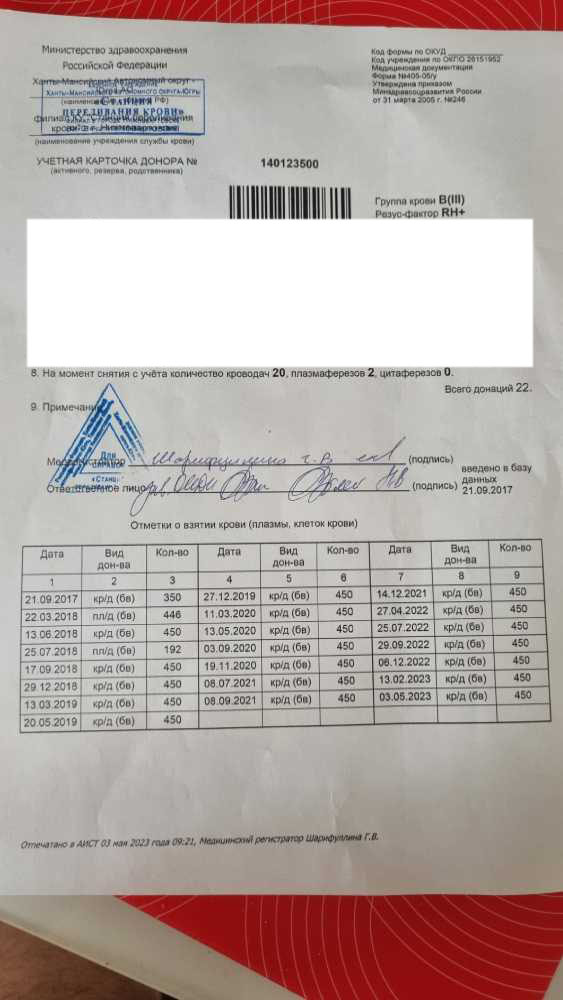

In [ ]:
cv2_imshow(cv2.imread(imgfile))

Найденная таблица без предообработки

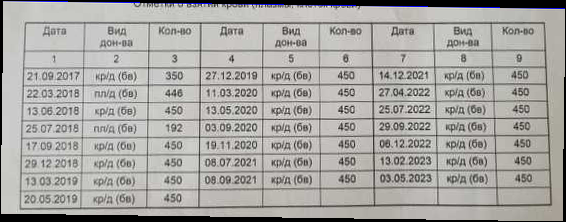

In [ ]:
cv2_imshow(rotation(imgfile))

Найденная таблица после обработки

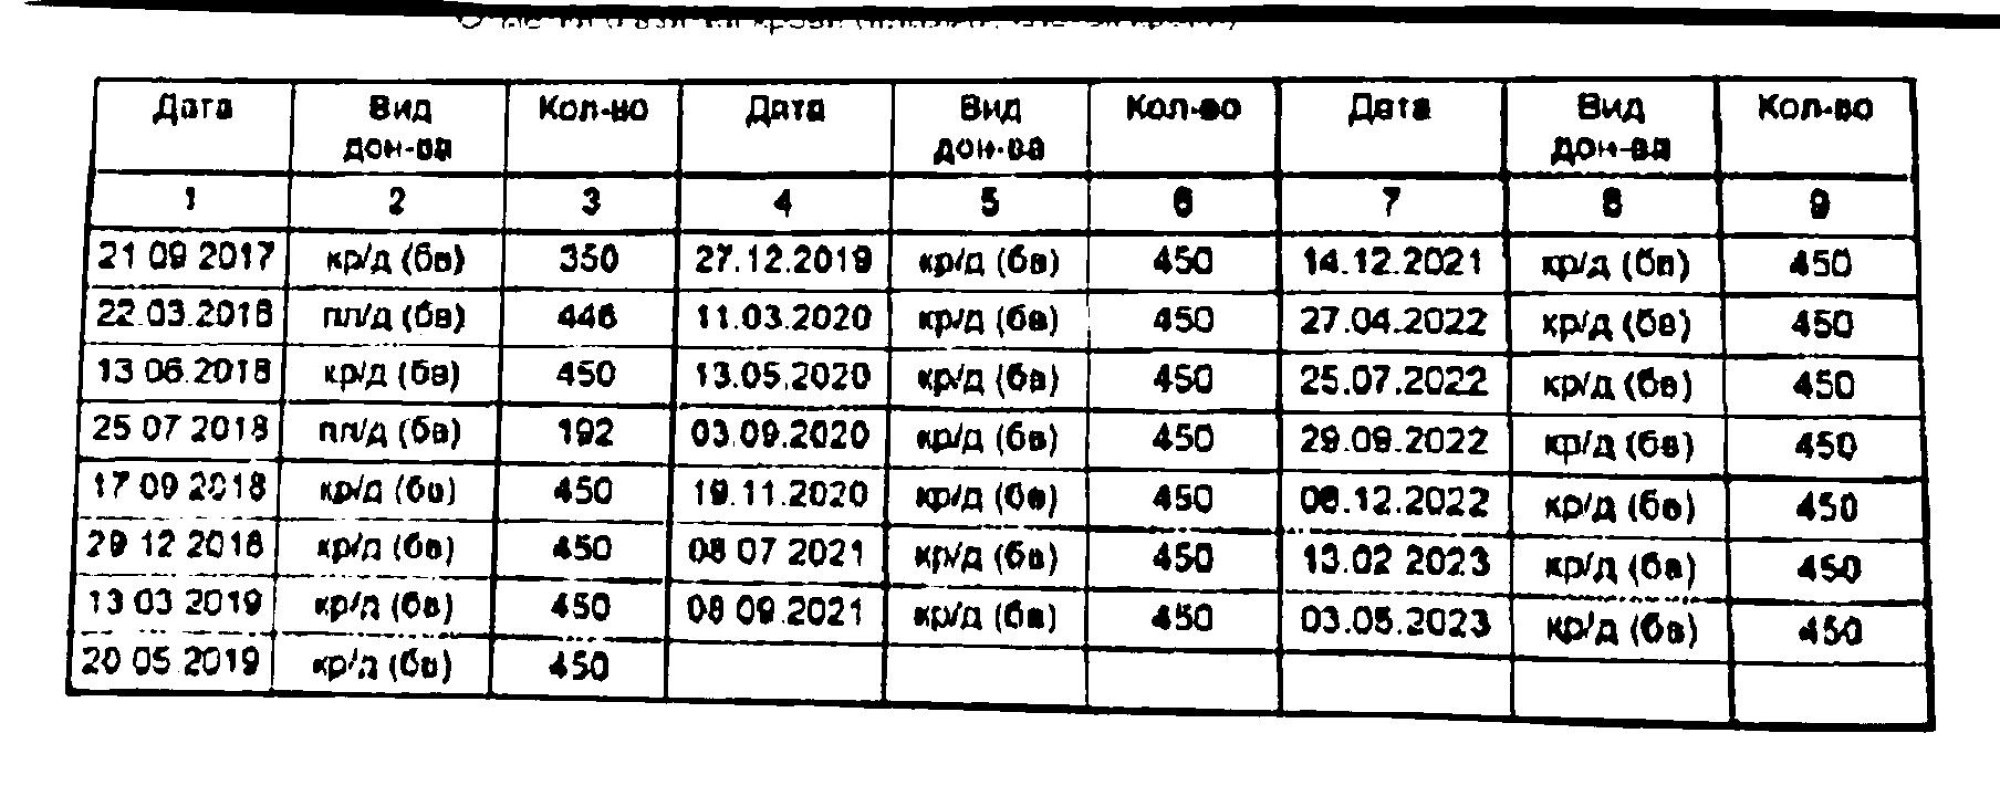

In [ ]:
cv2_imshow(rotation_dewarp(imgfile))

Визуализациация распознанного текста

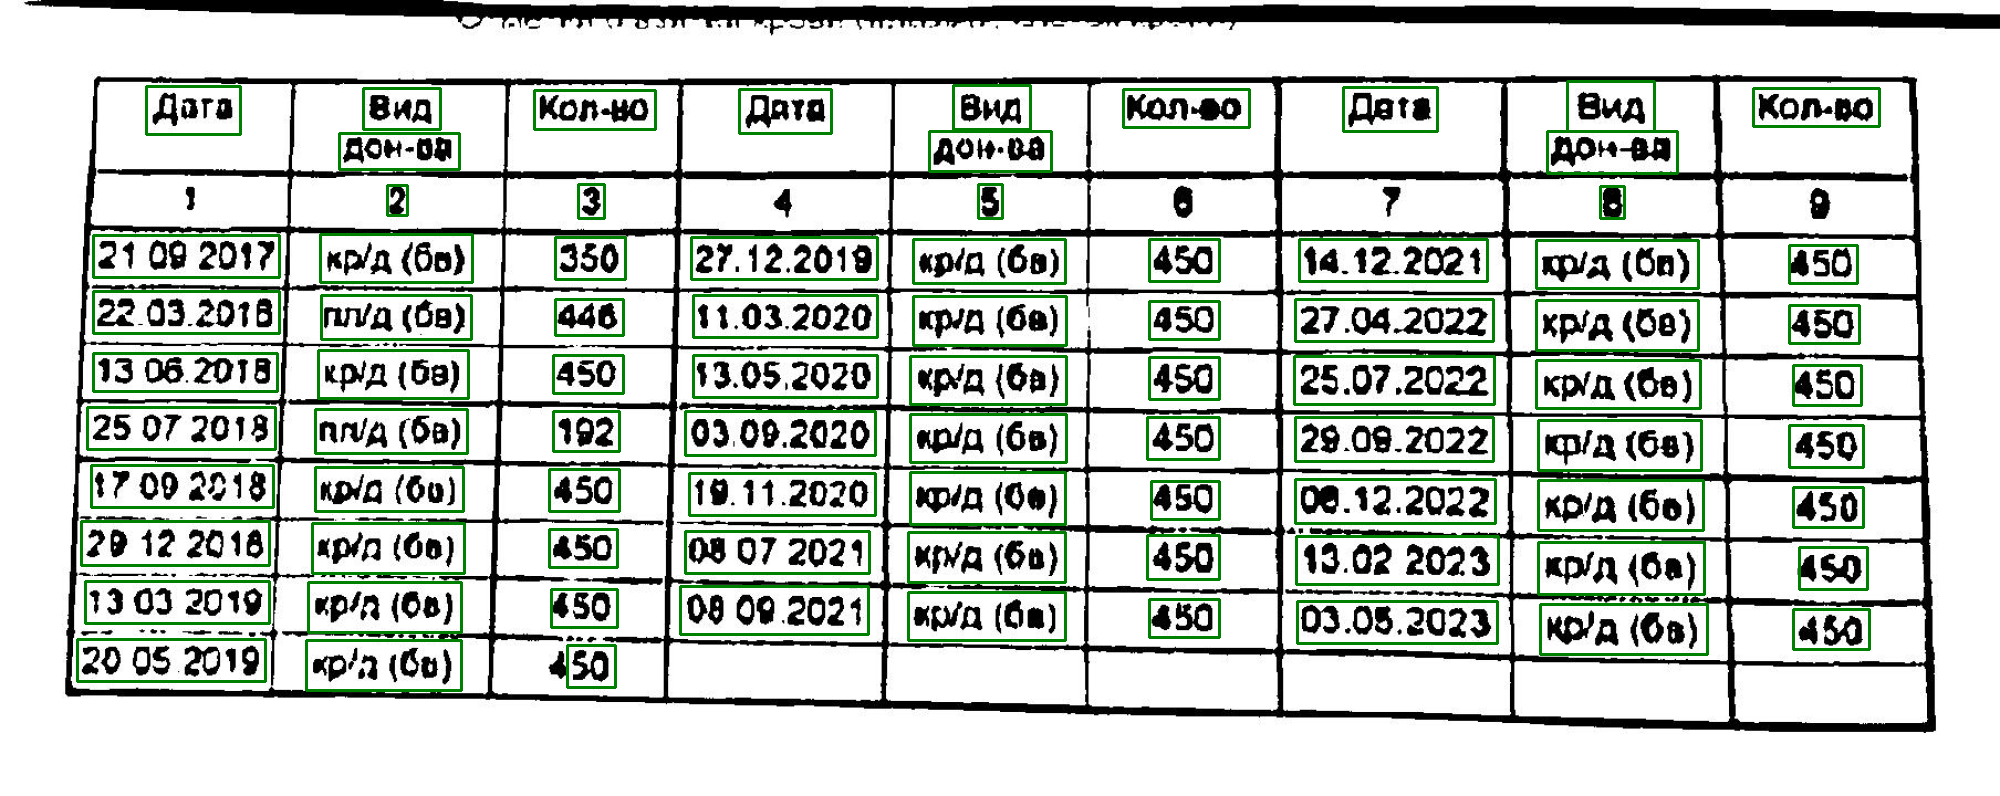

In [ ]:
#i = rotation(imgfile)
#im = Image.fromarray(rotation(imgfile).astype('uint8'))
#result = reader.readtext(rotation(imgfile), detail=1, text_threshold=0.1)

def  draw_boxes(image, bounds, color='green', width=3):
    draw = ImageDraw.Draw(image)
    for bound in bounds:
        p0, p1, p2, p3 = bound[0]
        draw.line([*p0,*p1,*p2,*p3,*p0], fill=color,width=width)
    return image.show()

draw_boxes(Image.fromarray(rotation_dewarp(imgfile).astype('uint8')), reader.readtext(rotation_dewarp(imgfile), detail=1, text_threshold=0.1))

Сформированная таблица с распознанным текстом с предобработкой

In [ ]:
table = get_table_dewarp(imgfile)
table

,0,1,2,3,4,5,6,7,8
0,Дага,Вир,кол-,Дпта,[ыд,колтю,Двта,Вид,кОп-ьо
1,-,дон-.я,-,-,дон 09,-,-,ДОн-оа,-
2,-,2,3,-,3,-,-,3,-
3,21 09 2017,кр/д (.},350,"21,12.2019",*9ц (б6},450,14.12.2021,@я (Оп),450
4,22.03.2016,ПЛд (Ов),446,11.03.2020,крд (60),450,27.04.2022,хаУд (00),450
5,13 06.2018,крад (бы),450,"13.05,2020",~рд {ба},450,"25.07,2022",крд (00),450
6,25 07 2018,п ; (ба),192,"03,09.2020",~ыд (бв),450,29.09.2022,{/д (66),450
7,17 09 ^218,кыа (60),450,19.11.2020,кОд (09),450,09.12.2022,к~/д (б6},450
8,20 12 2018,~~П (60),450,09 07 2021,к{; (6.},450,13.02 2023,крл (О4),450
9,13 01 2019,~р/а (О6),450,08 09.2021,~рУп ((1),350,03.05.2023,ко/д (О6},14*


Итоговая таблица после форматирования

In [ ]:
processing_dataset_after_OCR(table).drop('text', axis=1)

,Дата донации,Класс крови,Тип донации
0,22.03.2016,-,Безвозмездно
1,21.09.2017,Цельная кровь,-
2,13.06.2018,Цельная кровь,Безвозмездно
3,25.07.2018,Плазма,Безвозмездно
4,20.12.2018,-,Безвозмездно
5,13.01.2019,Цельная кровь,Безвозмездно
6,20.05.2019,Цельная кровь,Безвозмездно
7,21.12.2019,-,Безвозмездно
8,11.03.2020,Цельная кровь,Безвозмездно
9,13.05.2020,Цельная кровь,Безвозмездно


# Итоговая функция

In [ ]:
imgfile = '/content/drive/MyDrive/Yandex_workshop/initial_data/jpg/256838.jpg'
processing_dataset_after_OCR(get_table_dewarp(imgfile)).drop('text', axis=1)

,Дата донации,Класс крови,Тип донации
0,22.03.2016,-,Безвозмездно
1,21.09.2017,Цельная кровь,-
2,13.06.2018,Цельная кровь,Безвозмездно
3,25.07.2018,Плазма,Безвозмездно
4,20.12.2018,-,Безвозмездно
5,13.01.2019,Цельная кровь,Безвозмездно
6,20.05.2019,Цельная кровь,Безвозмездно
7,21.12.2019,-,Безвозмездно
8,11.03.2020,Цельная кровь,Безвозмездно
9,13.05.2020,Цельная кровь,Безвозмездно


# Test

In [ ]:
def acc(y_true, y_pred):

    true_counter = 0

    for row_true in range(len(y_true)):
        for row_pred in range(len(y_pred)):
            if y_true.loc[row_true, 'Дата донации'] == y_pred.loc[row_pred, 'Дата донации']:
                true_temp_counter = 1
                if y_true.loc[row_true, 'Класс крови'] == y_pred.loc[row_pred, 'Класс крови']:
                    true_temp_counter += 1
                if y_true.loc[row_true, 'Тип донации'] == y_pred.loc[row_pred, 'Тип донации']:
                    true_temp_counter += 1
                true_counter += true_temp_counter/3
    return true_counter/len(y_true)

In [ ]:
y_true = pd.read_csv('/content/drive/MyDrive/Yandex_workshop/initial_data/csv/256838.csv')
y_pred = processing_dataset_after_OCR(get_table_dewarp(imgfile)).drop('text', axis=1)

accuracy = acc(y_true, y_pred)
accuracy

0.5303030303030303

Сводная таблица разультатов точности распознавания таблицы

In [ ]:
data = {'file_name':[],
        'accuracy':[]}

# Функция перебирает все файлы из папки и оставляет от них только таблицы и сохраняет в указаную папку
for dirpath, _, filenames in os.walk('/content/drive/MyDrive/Yandex_workshop/initial_data/jpg'):

  for filename in filenames:

    img_path = os.path.join(dirpath, filename)

    basename = os.path.basename(img_path)

    name, _ = os.path.splitext(basename)

    name = name.rstrip()

    if name != '240493':
        y_pred = processing_dataset_after_OCR(get_table_dewarp(img_path)).drop('text', axis=1)

        y_true = pd.read_csv('/content/drive/MyDrive/Yandex_workshop/initial_data/csv/'+name+'.csv')

        accuracy = acc(y_true, y_pred)

        data['file_name'].append(name)
        data['accuracy'].append(accuracy)

    else:
        continue

In [ ]:
result_table = pd.DataFrame(data)
result_table

,file_name,accuracy
0,227414,0.933333
1,233749,0.968254
2,245365,0.918919
3,236000,1.000000
4,204119,1.000000
5,213950,1.000000
6,228963,0.000000
7,256578,0.000000
8,256838,0.530303
9,231820,1.000000
